# CS 429: Information Retrieval

<br>

## Lecture 11: Probabilistic IR, Part I

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


---

Last time:

- query expansion

This time:

- We'll derive something similar to $tfidf$ using probability theory.
- In the next lectures, we'll extend this to more sophisticated probabilistic ranking models.

**Goal:** Model the probability that a document is relevant.

$P(R=1|  d, q)$

- $R$: binary variable; 1 if document $d$ is relevant to query $q$


# Probability review

- **Chain rule**

$$P(A, B) \equiv P(A \cap B) = P(A|B)P(B) = P(B|A)P(A)$$

E.g.
$P$(old AND boring) $=$ $P$(old | boring) $P$(boring) $=$ $P$(boring | old) $P$(old)


- **Bayes' rule** (application of the chain rule)

$$P(A|B) = \frac{P(A,B)}{P(B)} = \frac{P(B|A)P(A)}{P(B)}$$


**Using Bayes' Rule**:

$$P(R=1| d,q) = \frac{P(d|R=1, q)P(R=1|q)}{P(d|q)}$$


- Why did we complicate things by turning one term into three?

- It will turn out to be easier to come up with estimates of those three simpler values.

Let's assume for now we can compute $P(R=1|d, q)$.

- How do we use it?


- Rank all documents by probability of relevance: $P(R=1|d,q)$.

Equivalently, we can rank documents by the **odds** of relevance:

$$\frac{P(R=1|d,q)}{P(R=0|d,q)}$$

This will produce the same rankings (since $P(R=1|d,q) + P(R=0|d,q) = 1$).



Using odds, the denominator of Bayes' rule cancels out:

$$\frac{P(d|R=1, q)P(R=1|q)}{P(d|q)} / \frac{P(d|R=0, q)P(R=0|q)}{P(d|q)}$$

$$= \frac{P(d|R=1, q)P(R=1|q)}{ P(d|R=0, q)P(R=0|q) }$$

Furthermore, the ratio $\frac{P(R=1|q)}{P(R=0|q)}$ is constant for every document

- So, it does not affect ranking.

The only terms remaining in our scoring function, then, are:

$$\frac{P(d|R=1, q)}{ P(d|R=0, q)}$$

$P(d|R=1,q)$ is the probability of seeing a relevant document $d$ given query $q$.

What is this, and how do we estimate it?

# Binary Independence Model

Each document represent by a binary term vector.

$d = \vec{x} = \{x_1, x_2, \ldots, x_n\}$

where $x_i=1$ if term $i$ appears in $d$ at least once.

- Frequency of term is ignored (for now).
- Word order ignored.

$P(d|R=1,q) = P(\vec{x}|R=1,q)$

**Conditional independence assumption**:

We assume that $x_i$ is conditionally independent of $x_j$ given $R,q$.

Recall notion of probabilistic independence:

If $A \perp\!\!\!\perp B$, then $P(A,B) = P(A)P(B)$.

- E.g., two flips of a coin

**Conditional independence:**

If $A \perp\!\!\!\perp B$ | $C$, then $P(A,B|C) = P(A|C)P(B|C)$.

- E.g., if a coin might be biased towards heads, then knowing the outcome of the first flip may influence my estimate for the second flip.
- But, knowing for sure the bias of the coin renders the two flips independent


Assuming conditional independence of $x$ given $R,q$:

$P(\vec{x}|R=1,q) = P(x_1|R=1,q)P(x_2|R=1,q) \ldots P(x_n|R=1,q)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $= \prod_i P(x_i | R=1, q)$

We've reduced the problem from "what's the probability of a relevant document" to "what's the probability of a relevant term"

Since each $x_i$ is either 0 or 1, we can re-write this as:

$$P(\vec{x}|R=1,q) = \prod_{i:x_i=1}P(x_i=1|R=1,q) \prod_{i:x_i=0}P(x_i=0|R=1,q)$$

- where $i:x_i=1$ means loop over terms that are in the document.
- and $i:x_i=0$ means loop over terms that are not in the document.

We can make a table of the various probabilities we need to estimate:

<table>
<tr><td> </td><td> </td><td colspan=2>R</td></tr>
<tr><td> </td><td> </td><td>R=1</td><td>R=0</td></tr>
<tr><td rowspan=2>$x_i$</td><td>$x_i$=1</td><td>$p_i$</td><td>$u_i$</td></tr>
<tr><td>$x_i$=0</td><td>1-$p_i$</td><td>1 - $u_i$</td></tr>
</table>

- $p_i$: probability of seeing word $x_i$ in a document that is relevant to the query.
- $u_i$: probability of seeing word $x_i$ in a document that is **not** relevant to the query.
- $1-p_i$: probability of **not** seeing word $x_i$ in a document that is relevant to the query.
- $1-u_i$: probability of **not** seeing word $x_i$ in a document that is **not** relevant to the query.

We can substitute in the values from the table in our calculations:

$P(\vec{x}|R=1,q) = \prod_{i:x_i=1}P(x_i=1|R=1,q) \prod_{i:x_i=0}P(x_i=0|R=1,q)$

  $=\prod_{i:x_i=1}p_i \prod_{i:x_i=0}(1-p_i)$
  
and for non-relevance:

$P(\vec{x}|R=0,q) = \prod_{i:x_i=1}P(x_i=1|R=0,q) \prod_{i:x_i=0}P(x_i=0|R=0,q)$

  $=\prod_{i:x_i=1}u_i \prod_{i:x_i=0}(1-u_i)$


Our odds ratio can now be written as:

$$\frac{P(d|R=1, q)}{ P(d|R=0, q)} = \prod_{i:x_i=1}\frac{p_i}{u_i} \prod_{i:x_i=0}\frac{(1-p_i)}{(1-u_i)}$$

These products currently loop over all words in a document, even those not in the query.

We make the assumption that the words in the query are the only ones that matter:

$$\frac{P(d|R=1, q)}{ P(d|R=0, q)} = \prod_{i:x_i=q_i=1}\frac{p_i}{u_i} \prod_{i:x_i=0,q_i=1}\frac{(1-p_i)}{(1-u_i)}$$

- where $i:x_i=q_i=1$ means that both the query and document contain term $x_i$
- and $i:x_i=0,q_i=1$ means that the query contains the term, but the document doesn't

We can cleverly re-arrange these terms to:

$$\frac{P(d|R=1, q)}{ P(d|R=0, q)} = \prod_{i:x_i=q_i=1}\frac{p_i(1-u_i)}{u_i(1-p_i)} \prod_{i:q_i=1}\frac{(1-p_i)}{(1-u_i)}$$

where now the second product is document independent, so we can ignore it from the ranking score.

Finally, we are left as our ranking function:

$$\frac{P(d|R=1, q)}{ P(d|R=0, q)} = \prod_{i:x_i=q_i=1}\frac{p_i(1-u_i)}{u_i(1-p_i)}$$

as a reminder:

- $p_i$: probability of seeing word $x_i$ in a document that is relevant to the query.
- $u_i$: probability of seeing word $x_i$ in a document that is **not** relevant to the query.
- $1-p_i$: probability of **not** seeing word $x_i$ in a document that is relevant to the query.
- $1-u_i$: probability of **not** seeing word $x_i$ in a document that is **not** relevant to the query.

For numerical reasons, we typically take the log of this, which is called the *Retrieval Status Value (RSV)*:

$$RSV(d) = \log \prod_{i:x_i=q_i=1}\frac{p_i(1-u_i)}{u_i(1-p_i)} = \sum_{i:x_i=q_i=1}\log\frac{p_i(1-u_i)}{u_i(1-p_i)}$$



$$= \sum_{i:x_i=q_i=1} \log \frac{p_i}{1-p_i} + \log\frac{1-u_i}{u_i}$$

$RSV(d)$ will be used to rank each document $d$

# Estimation

We still need to estimate 

- $p_i$: probability of seeing word $x_i$ in a document that is relevant to the query.
- $u_i$: probability of seeing word $x_i$ in a document that is **not** relevant to the query.

Given a set of documents $D=\{d_1 \ldots d_N\}$, what is the probability of seeing word $x_i$?

Just count:

(number of documents containing $x_i$) / $N$

To estimate $u_i$ (prob. of $x_i$ in a non-relevant document)

- Given a very large collection, most documents are not relevant to a query.
- So, we can estimate $u_i$ as simply the probability of seeing $x_i$ in *any* document...
- Which is just *document frequency*!

$u_i = \frac{df_i}{N}$



Thus

$\log\frac{1-u_i}{u_i} = \log\frac{1-\frac{df_i}{N}}{\frac{df_i}{N}} = \log \frac{N-df_i}{df_i} \approx \log \frac{N}{df_i}$

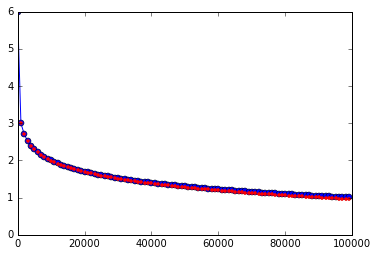

[6.0, 2.999565922520681, 2.6987529113637887, 2.522734004575147, 2.3978314486210026, 2.300943145452332, 2.2217763732339035, 2.1548399223480543, 2.0968557295904615, 2.045709238298873, 1.0457526650932398, 1.0409538352382945, 1.0362074520879054, 1.0315123816380325, 1.0268675262708136, 1.0222718232143506, 1.0177242430831401, 1.0132237884941335, 1.0087694927537691, 1.004360418611657]
[5.999999565705301, 2.999130976017235, 2.6978830174861304, 2.521428727285299, 2.396090351005846, 2.298765789720972, 2.2191623207150193, 2.1517887334872414, 2.0933669639475627, 2.041782454545298, 1.0047935801673877, 0.9995172406882918, 0.9942928223108395, 0.9891191898726357, 0.9839952445936294, 0.9789199225358833, 0.9738921931439879, 0.968911057861103, 0.963975548815974, 0.9590847275765991]


In [3]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

def idf1(N, df):
    return math.log10(1. * N / df)
def idf2(N, df):
    return math.log10(1. * (N - df) / df)

N = 1000000
dfs = range(1,100000)[::1000]
plt.figure()
idfs1 = [idf1(N, df) for df in dfs]
idfs2 = [idf2(N, df) for df in dfs]
plt.plot(dfs, [idf1(N, df) for df in dfs], 'bo-')
plt.plot(dfs, [idf2(N, df) for df in dfs], 'r.')
plt.show()
print(idfs1[:10] + idfs1[-10:])
print(idfs2[:10] + idfs2[-10:])

Plugging this back into the RSV equation:

$$RSV(d) = \sum_{i:x_i=q_i=1} \log \frac{p_i}{1-p_i} + \log\frac{1-u_i}{u_i}$$

$$= \sum_{i:x_i=q_i=1} \log \frac{p_i}{1-p_i} + \log\frac{N}{df_i}$$

How should we estimate $p_i$? (probability of seeing word $x_i$ in a relevant document)

1. Ignore it! Then, we rank documents only by $idf$
2. Ask a human for relevance judgements. (*expensive*)
3. Use click log data.
4. Assume the top $k$ retrieved results are relevant, then estimate from that (psuedo-relevance feedback)

# Psuedo-relevance Feedback

1. Initialize $p_i \leftarrow 0.5$.
2. Rank documents by $RSV(d)$.
3. Let $V$ be the top $k$ documents. We pretend these are all relevant.
4. We then update $p_i$ to be the proportion of elements of $V$ that contain term $x_i$
  - $p_i = $ (number of documents containing $x_i$ in $V$) / $|V|$
  
We can iterate steps $2-4$ until ranking stops changing.